In [170]:
'''1. 주식,날짜를 입력해 토픽과 주가를 비교하는 그래프 생성
   2. 키워드 밑에 가장 연관된 뉴스 url 또는 제목'''

'1. 주식,날짜를 입력해 토픽과 주가를 비교하는 그래프 생성\n   2. 키워드 밑에 가장 연관된 뉴스 url 또는 제목'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from konlpy.tag import Mecab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np
from pykrx import stock
import datetime
import numpy as np
import matplotlib
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def tokenizer(text):
    text = Mecab().nouns(text)
    return [word for word in text if len(word)>1]

class topic_stock():
    def __init__(self,start,end,etf_code):
        news = pd.read_excel(f'.\\파이썬+텍스트+분석+입문\\파이썬 텍스트 분석 입문\\data\\NewsResult_{str(start)}-{str(end)}.xlsx')
        news = news.dropna(axis=1)
        self.news = news

        # # 수정 2 : 기사가 10개 미만이었던 날이 있었기 때문에 생략되었으므로 그냥하기로함
        # data = []
        # for date in news['일자'].unique():
        #     d_news = news.loc[news['일자'] == date,'본문']

        #     if len(d_news)>10:
        #         # 본문 내용의 끝에 '기사 끝'이란 단어를 추가해 붙여줌
        #         text = '기사 끝'.join(d_news.to_list())
        #         data.append({'date':date,'text':text})


        data = []
        for date in news['일자'].unique():
            d_news = news.loc[news['일자'] == date,'본문']

            # 본문 내용의 끝에 '기사 끝'이란 단어를 추가해 붙여줌
            text = '기사 끝'.join(d_news.to_list())
            data.append({'date':date,'text':text})


        dateNews = pd.DataFrame(data)
        dateNews['date'] = pd.to_datetime(dateNews['date'].map(str))
        self.dateNews = dateNews

        self.vectorizer = TfidfVectorizer(tokenizer=tokenizer,
                            max_df=0.90,
                            min_df=2,
                            max_features=5000)
        self.dateW_matrix = self.vectorizer.fit_transform(dateNews['text'])

        nmf = NMF(n_components=20, alpha=0.2, random_state=3)
        self.dateT = nmf.fit_transform(self.dateW_matrix)
        self.TW = nmf.components_

        # 옵션 1 : 주말장의 값은 미래장의 값으로 채운다.
        raw = stock.get_etf_ohlcv_by_date(start,end,etf_code)
        # pd.merge(KOSPI_df['Close'],pivot,on='Date')
        df1 = pd.DataFrame(np.nan,index=pd.date_range(start, end),columns=['dummy'])
        df1 = pd.merge(raw,df1,how='outer',left_index=True,right_index=True)
        df1.dropna(how='all',axis='columns',inplace=True)
        # 끝부분에서 공휴일일수도 있기 때문에 이땐 전장의 값을 채워야하지만 그냥 평일날것만 수집하는게 코드가 클린하다.
        self.df = df1.fillna(method='bfill')
        # self.df = pd.concat([df1[:-3].fillna(method='bfill'),df1[-3:].fillna(method='ffill')],axis=0)
        print(self.df.shape)
        # # 옵션2 : 전일장과 같은 값으로 주말값을 채우기
        # self.df = pd.concat([df1[:4].fillna(method='bfill'),df1[4:].fillna(method='ffill')],axis=0)

        # topic마다 상위 빈도 5개 출력
        self.topic = []
        for topic_idx, word_vec in enumerate(self.TW):
            message = "Topic %d: " % topic_idx

            message += " ".join(["#"+self.vectorizer.get_feature_names()[i]
                         for i in word_vec.argsort()[:-6:-1]])
            self.topic.append(message)

    def print_top_words(self, n_top_words=5):
        for topic_idx, word_vec in enumerate(self.TW):
            message = "Topic %d: " % topic_idx

            message += " ".join(["#"+self.vectorizer.get_feature_names()[i]
                         for i in word_vec.argsort()[:-n_top_words - 1:-1]])

            print(message)

    def print_load_top_doc(self, topic_id, n_top_words=5, n_top_titles=10):
        '''토픽과 가장 관련된 기사의 본문과 제목 출력
        dateT에서 topic과 가장 연관된 date에 본문,제목 5개 출력
        너무 기니까 각기사 안의 토픽의 빈도수가 가장 높은 문서 5개를 출력해보자'''

        '''수정1 텍스트 파일 형태로 저장'''

    

        # topic_id에 가장관련된 한 날짜의 본문들을 기사 끝이라는 것으로 분할해 리스트로 만든다. '기사 끝'으로 구분된 기사 본문을 리스트로 만들기
        text_list = self.dateNews.iloc[self.dateT.T[topic_id].argsort()[-1],1].split('기사 끝')
        text_list_df = pd.DataFrame(text_list,columns=['본문'])

        vectorizer = TfidfVectorizer(tokenizer=tokenizer,
                            max_df=0.90,
                            min_df=2,
                            max_features=1000,
                            )
        # 한 날짜의 본문들을 벡터화한다.
        DW_matrix = vectorizer.fit_transform(text_list_df['본문'])
        
        nmf = NMF(n_components=3)
        DT = nmf.fit_transform(DW_matrix)
        TW = nmf.components_

        # 밑의 인덱싱을 위해서 인덱스 유지를 위해 left dataframe는 고정시킨채 '본문'칼럼을 기준으로(on='본문') merge
        topic_news = pd.merge(self.news, text_list_df, how='right', on='본문')

        data = ['-'*10+f'{self.topic[topic_id]}와 가장 밀접한 날짜의 뉴스분석'+'-'*10]
        print(str(data))
        # 토픽 단어 5개 + 기사 제목 + 기사 url
        for topic_idx, (doc_vec, word_vec) in enumerate(zip(DT.T, TW)):
            message = "\nTopic %d: " % topic_idx
            # 토픽 단어    
            message += "#"+" #".join([vectorizer.get_feature_names()[i]
                        for i in word_vec.argsort()[:-n_top_words - 1:-1]])
            
            message += '\n\n'
            # 기사 제목
            message += "\n".join([topic_news.iloc[i,3]
                        for i in doc_vec.argsort()[:-n_top_titles - 1:-1]])

            message += "\n\n"
            # 기사 url
            message += "\n".join([topic_news.iloc[i,8]
                        for i in doc_vec.argsort()[:-n_top_titles - 1:-1]])
            data.append(message)
            print(message)

        f = open("C:\\Users\\JAEHO\\Desktop\\textanalysis.txt", 'w')
        f.write('\n'.join(data))
        f.close()


    def graph1(self, n_topics, 비교항목):
        sns.set_style("darkgrid")
        matplotlib.rcParams['font.family'] = 'NanumGothic'

        fig, (ax1,ax2) = plt.subplots(2,1,sharex=True) #squeeze = True라 일차원이 된다.
        for topic_id in range(n_topics):
            label = "Topic #%d:\n" % topic_id
            label += " ".join([self.vectorizer.get_feature_names()[i]
                             for i in self.TW[topic_id].argsort()[:-6:-1]])
    
            h = self.dateT / self.dateT.sum(1, keepdims=True)
            h = h[:, topic_id].ravel()

            ax1.plot(self.dateNews['date'], h)
            ax1.fill_between(self.dateNews['date'], h, alpha=0.5, label=label)
            ax1.legend(fontsize=10, bbox_to_anchor=(0.1, 0.2))
            
        ax2.plot(self.df.index,self.df[비교항목],label='주가')
        ax2.set_ylabel('원')
        ax2.legend(fontsize=10)

        plt.show()

    def graph2(self, start_topic, end_topic, 비교항목):
        fig, ax1 = plt.subplots() #squeeze = True라 일차원이 된다.

        count = range(20)[start_topic:end_topic]
        for topic_id in count:
            label = "Topic #%d:\n" % topic_id
            label += " ".join([self.vectorizer.get_feature_names()[i]
                             for i in self.TW[topic_id].argsort()[:-6:-1]])
    
            h = self.dateT / self.dateT.sum(1, keepdims=True)
            h = h[:, topic_id].ravel()

            ax1.plot(self.dateNews['date'], h)
            ax1.fill_between(self.dateNews['date'], h, alpha=0.5, label=label)
            ax1.legend(fontsize=10, bbox_to_anchor=(0.1, 0.2))


        ax2 = ax1.twinx()
        ax2.plot(self.df.index,self.df[비교항목],'r--',label=비교항목)
        ax2.set_ylabel('원')
        ax2.legend(fontsize=10)

        plt.show()

    # 수정 3 : 연관분석 추가
    def topic_stock_corr(self, start_topic, end_topic, 비교항목):
        # dateT와 주식 df를 합친다.
        print(self.dateT.shape)
        dateT = pd.DataFrame(self.dateT,index=self.df.index)
        df = pd.merge(dateT,self.df,how='outer',left_index=True,right_index=True)
        corr = df.corr(method='pearson')
        return corr.iloc[:20,20:]

In [160]:
a=topic_stock('20201128','20211128','244580')

C:\Users\JAEHO\anaconda3\envs\py37-64\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\JAEHO\anaconda3\envs\py37-64\lib\site-packages\sklearn\decomposition\_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


(366, 8)


In [161]:
b=a.topic_stock_corr(0,3,'거래량')

(366, 20)


In [168]:
b

,NAV,시가,고가,저가,종가,거래량,거래대금,기초지수
0,-0.307305,-0.312832,-0.308764,-0.316239,-0.307400,0.031738,0.001694,-0.304601
1,0.607567,0.612267,0.627327,0.577863,0.605347,0.333082,0.389855,0.605089
2,0.011509,0.000171,-0.000023,0.011490,0.009447,-0.115093,-0.114596,0.007725
3,0.097676,0.102897,0.094402,0.113736,0.098017,0.113984,0.110839,0.101193
4,-0.124766,-0.115502,-0.128949,-0.107918,-0.123774,0.014338,-0.002045,-0.125545
5,-0.036171,-0.063298,-0.056736,-0.050374,-0.038765,-0.036421,-0.038672,-0.039149
6,0.200387,0.218437,0.212217,0.209074,0.200157,-0.068325,-0.053457,0.196234
7,0.120636,0.114598,0.110177,0.128221,0.120971,-0.057707,-0.053062,0.125435
8,0.063490,0.072127,0.068271,0.068303,0.062925,-0.053006,-0.043553,0.061379
9,-0.445638,-0.454956,-0.445069,-0.467274,-0.442563,-0.055296,-0.092270,-0.442383


In [169]:
a.print_load_top_doc(15)

['----------Topic 15: #미군 #내년 #영국 #주한 #확보와 가장 밀접한 날짜의 뉴스분석----------']

Topic 0: #백신 #접종 #코로나 #화이자 #독일

화이자 백신 ‘초저온 냉동’ 운송 보관 문제 잇따라 한국 대응은?
세상을 구하러 나선 ‘수퍼 콜드 체인’
[제약&바이오] "코로나19 치료제 선점한다" 개발 가속도 붙은 K바이오
英, 아스트라 백신 1월4일부터 화이자와 같이 맞는다
美 인도태평양사령관 백신 접종사진 공개 주한미군 29일부터
獨서 첫 백신 맞은 101세 할머니 “이제 안심됩니다”
EU, 동시다발 백신 접종 "감동적 통합의 순간, 다시 뭉치자"
“백신 함께 맞아요” 獨 상공에 펼쳐진 대형 주사기
[시사중국어학원]백신 복권
백신 안 맞으면 해외 못간다? 美 EU '백신 여권' 개발 착수

https://www.donga.com/news/article/all/20201228/104669987/1
https://www.chosun.com/economy/mint/2020/12/28/HFK3TZO5PZHMJBP4U6TXGDTMSY/?utm_source=bigkinds&utm_medium=original&utm_campaign=news
https://news.joins.com/article/olink/23550229
https://www.chosun.com/international/europe/2020/12/28/MN6TEQS2F5A3LHYULDWGNB4P3E/?utm_source=bigkinds&utm_medium=original&utm_campaign=news
https://www.donga.com/news/article/all/20201228/104667672/1
https://www.donga.com/news/article/all/20201227/104655792/1
https://news.joins.com/article/olink/23550941
https://www.donga.com/news/article/all/

C:\Users\JAEHO\anaconda3\envs\py37-64\lib\site-packages\sklearn\decomposition\_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


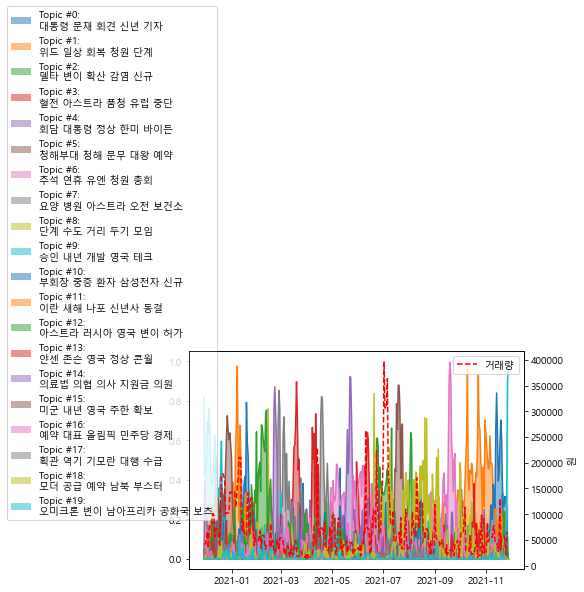

In [164]:
a.graph2(0,20,'거래량')

In [165]:
a.print_top_words()

Topic 0: #대통령 #문재 #회견 #신년 #기자
Topic 1: #위드 #일상 #회복 #청원 #단계
Topic 2: #델타 #변이 #확산 #감염 #신규
Topic 3: #혈전 #아스트라 #품청 #유럽 #중단
Topic 4: #회담 #대통령 #정상 #한미 #바이든
Topic 5: #청해부대 #청해 #문무 #대왕 #예약
Topic 6: #추석 #연휴 #유엔 #청원 #총회
Topic 7: #요양 #병원 #아스트라 #오전 #보건소
Topic 8: #단계 #수도 #거리 #두기 #모임
Topic 9: #승인 #내년 #개발 #영국 #테크
Topic 10: #부회장 #중증 #환자 #삼성전자 #신규
Topic 11: #이란 #새해 #나포 #신년사 #동결
Topic 12: #아스트라 #러시아 #영국 #변이 #허가
Topic 13: #얀센 #존슨 #영국 #정상 #콘월
Topic 14: #의료법 #의협 #의사 #지원금 #의원
Topic 15: #미군 #내년 #영국 #주한 #확보
Topic 16: #예약 #대표 #올림픽 #민주당 #경제
Topic 17: #획관 #역기 #기모란 #대행 #수급
Topic 18: #모더 #공급 #예약 #남북 #부스터
Topic 19: #오미크론 #변이 #남아프리카 #공화국 #보츠


In [166]:
a.print_load_top_doc(0)


['----------Topic 0: #대통령 #문재 #회견 #신년 #기자와 가장 밀접한 날짜의 뉴스분석----------']

Topic 0: #대통령 #기자 #회견 #신년 #문재인

“가운데 손가락 불경” “그게 질문이냐” 기자들에 ‘양념질’ 한 친문
文기자회견에 與 “국민과 소통 노력 돋보여” vs 野 “역대 최저 수준”
야당, 文 신년 기자회견 맹비난 진중권은 "박근혜 정부 떠올라"
코로나 낙관 발언때마다 확진 폭발  '문재인 징크스' 이번엔
“기자가 손가락 욕” 親文 주장에 “얼토당토 않은 억측”
文 기자회견에 與 “소통 노력” vs 野 “역대 최저”
[김필규의 아하, 아메리카] 공화당 지지자와 증오단체의 경계 무너진 트럼프 집회
文 "지금은 사면할 때 아니다"  '추 윤' 갈등엔 "민주주의 과정"
[청계천 옆 사진관]한번도 경험해보지 못한 언택트 기자회견 어떤 모습?
文 “백신 접종, 대통령 우선순위 될 필요 없다”

https://www.chosun.com/politics/2021/01/18/QZXAL3ZEABGLFJKOWAZUOWY6GY/?utm_source=bigkinds&utm_medium=original&utm_campaign=news
https://news.joins.com/article/olink/23567328
https://news.joins.com/article/olink/23567696
https://news.joins.com/article/olink/23567293
https://www.donga.com/news/article/all/20210118/104980988/2
https://www.donga.com/news/article/all/20210118/104974258/2
https://news.joins.com/article/olink/23566959
https://news.joins.com/article/olink/23567552
https://www.donga.com/news/article/all/20210118/104

C:\Users\JAEHO\anaconda3\envs\py37-64\lib\site-packages\sklearn\decomposition\_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


In [ ]:
news = pd.read_excel(f'.\\파이썬+텍스트+분석+입문\\파이썬 텍스트 분석 입문\\data\\NewsResult_20201128-20211128.xlsx')
news = news.dropna(axis=1)

data = []
for date in news['일자'].unique():
    d_news = news.loc[news['일자'] == date,'본문']

    if len(d_news)>10:
        text = '기사 끝'.join(d_news.to_list())
        data.append({'date':date,'text':text})

dateNews = pd.DataFrame(data)
dateNews['date'] = pd.to_datetime(dateNews['date'].map(str))
    

C:\Users\JAEHO\anaconda3\envs\py37-64\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
vectorizer = TfidfVectorizer(tokenizer=tokenizer,
                            max_df=0.90,
                            min_df=2,
                            max_features=5000)
dateW_matrix = vectorizer.fit_transform(dateNews['text'])

nmf = NMF(n_components=20, alpha=0.2, random_state=3)
dateT = nmf.fit_transform(dateW_matrix)

C:\Users\JAEHO\anaconda3\envs\py37-64\lib\site-packages\sklearn\decomposition\_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)
C:\Users\JAEHO\anaconda3\envs\py37-64\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [ ]:
text_list = dateNews.iloc[dateT.T[0].argsort()[-1],1].split('기사 끝')

In [ ]:
a = pd.DataFrame(text_list,columns=['본문'])

In [ ]:
b=pd.merge(news,a,how='inner',on='본문') # 본문이라는 같은 키(inner)로 merge

In [ ]:
c=b[:5]

In [ ]:
c[-1:]

,뉴스 식별자,일자,언론사,제목,통합 분류1,키워드,특성추출(가중치순 상위 50개),본문,URL
4,1.100901e+06,20210205,중앙일보,"SK바이오사이언스, 증권신고서 제출 공모액 최대 1조5000억",경제>증권_증시,"SK바이오사이언스,증권,신고서,제출,공모액,최대,SK바이오사이언스,본격적,절차,유가...","오사이언스,sk바이오사이언스,주간사,관계자,증권신고서,각국,파이프라인,이틀간,sk,...",SK바이오사이언스가 본격적인 유가증권 공모 절차에 돌입했다. 3월 내 상장이 목표다...,https://news.joins.com/article/olink/23581627


In [ ]:
b.iloc[1,3]

"AZ '고령층 접종' 판단 유보에 1분기 접종계획 차질우려"